## Final Project Submission

Please fill out:
* Student name: Adam Pell
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Morgan Jones
* Blog post URL:


<img src="https://logos-world.net/wp-content/uploads/2020/09/Microsoft-Logo.png" alt="Microsoft Logo" width="400" align='left'>

# Microsoft Movie Studios- Industry Analysis

# Overview

This projcet analyzes movie data to provide three actionable business recommendations for Microsoft as they look to make an entry into the film industry.

Descriptive analysis of budget, genre, runtime, and revenue data shows that multiple movies across a wide array of budgets, genres, and runtimes is most likely to balance high revenue with strong returns. Microsoft can use this analysis to inform their financial and creative decisions as their new studio looks to gain market share in a highly competitive space.

# Business Problem

Microsoft wants to make an effective entry into the movie business. To do so, there are many crucial decisions that will have a direct outcome on the performance of their films.

Using data from various public movie databases, I will find patterns that speak to key factors in a movie's profitability and make recommendations based on my findings. These recommendations will better inform Microsoft's planning and increase the chances of success at the box office.

# Data Understanding

The available data consists of six databases available from various sources:
- IMDb
- Box Office Mojo
- Rotten Tomatoes
- The Movie Database (TMDb)
- The Numbers

All of these databases come from large and well-trusted film websites containing information on budgets, genres, runtimes, cast, and reviews. While certain tables may not contain the same movies as one another, most fit a general format, identifying movies with a unique ID that corresponds to subsequent information. Each table generally contains different information about a given film.

For this analysis, I will primarily be working with IMDb, The Numbers, and TMDb:

- IMDb's SQLite database covers a wide range of information that includes genre, runtime, cast, and reception 
- The Numbers' database contains information on budgets as well as domestic and worldwide revenue 
- TMDb's database includes detailed genre information based on genre IDs

Image: IMDb SQLite Database Schema

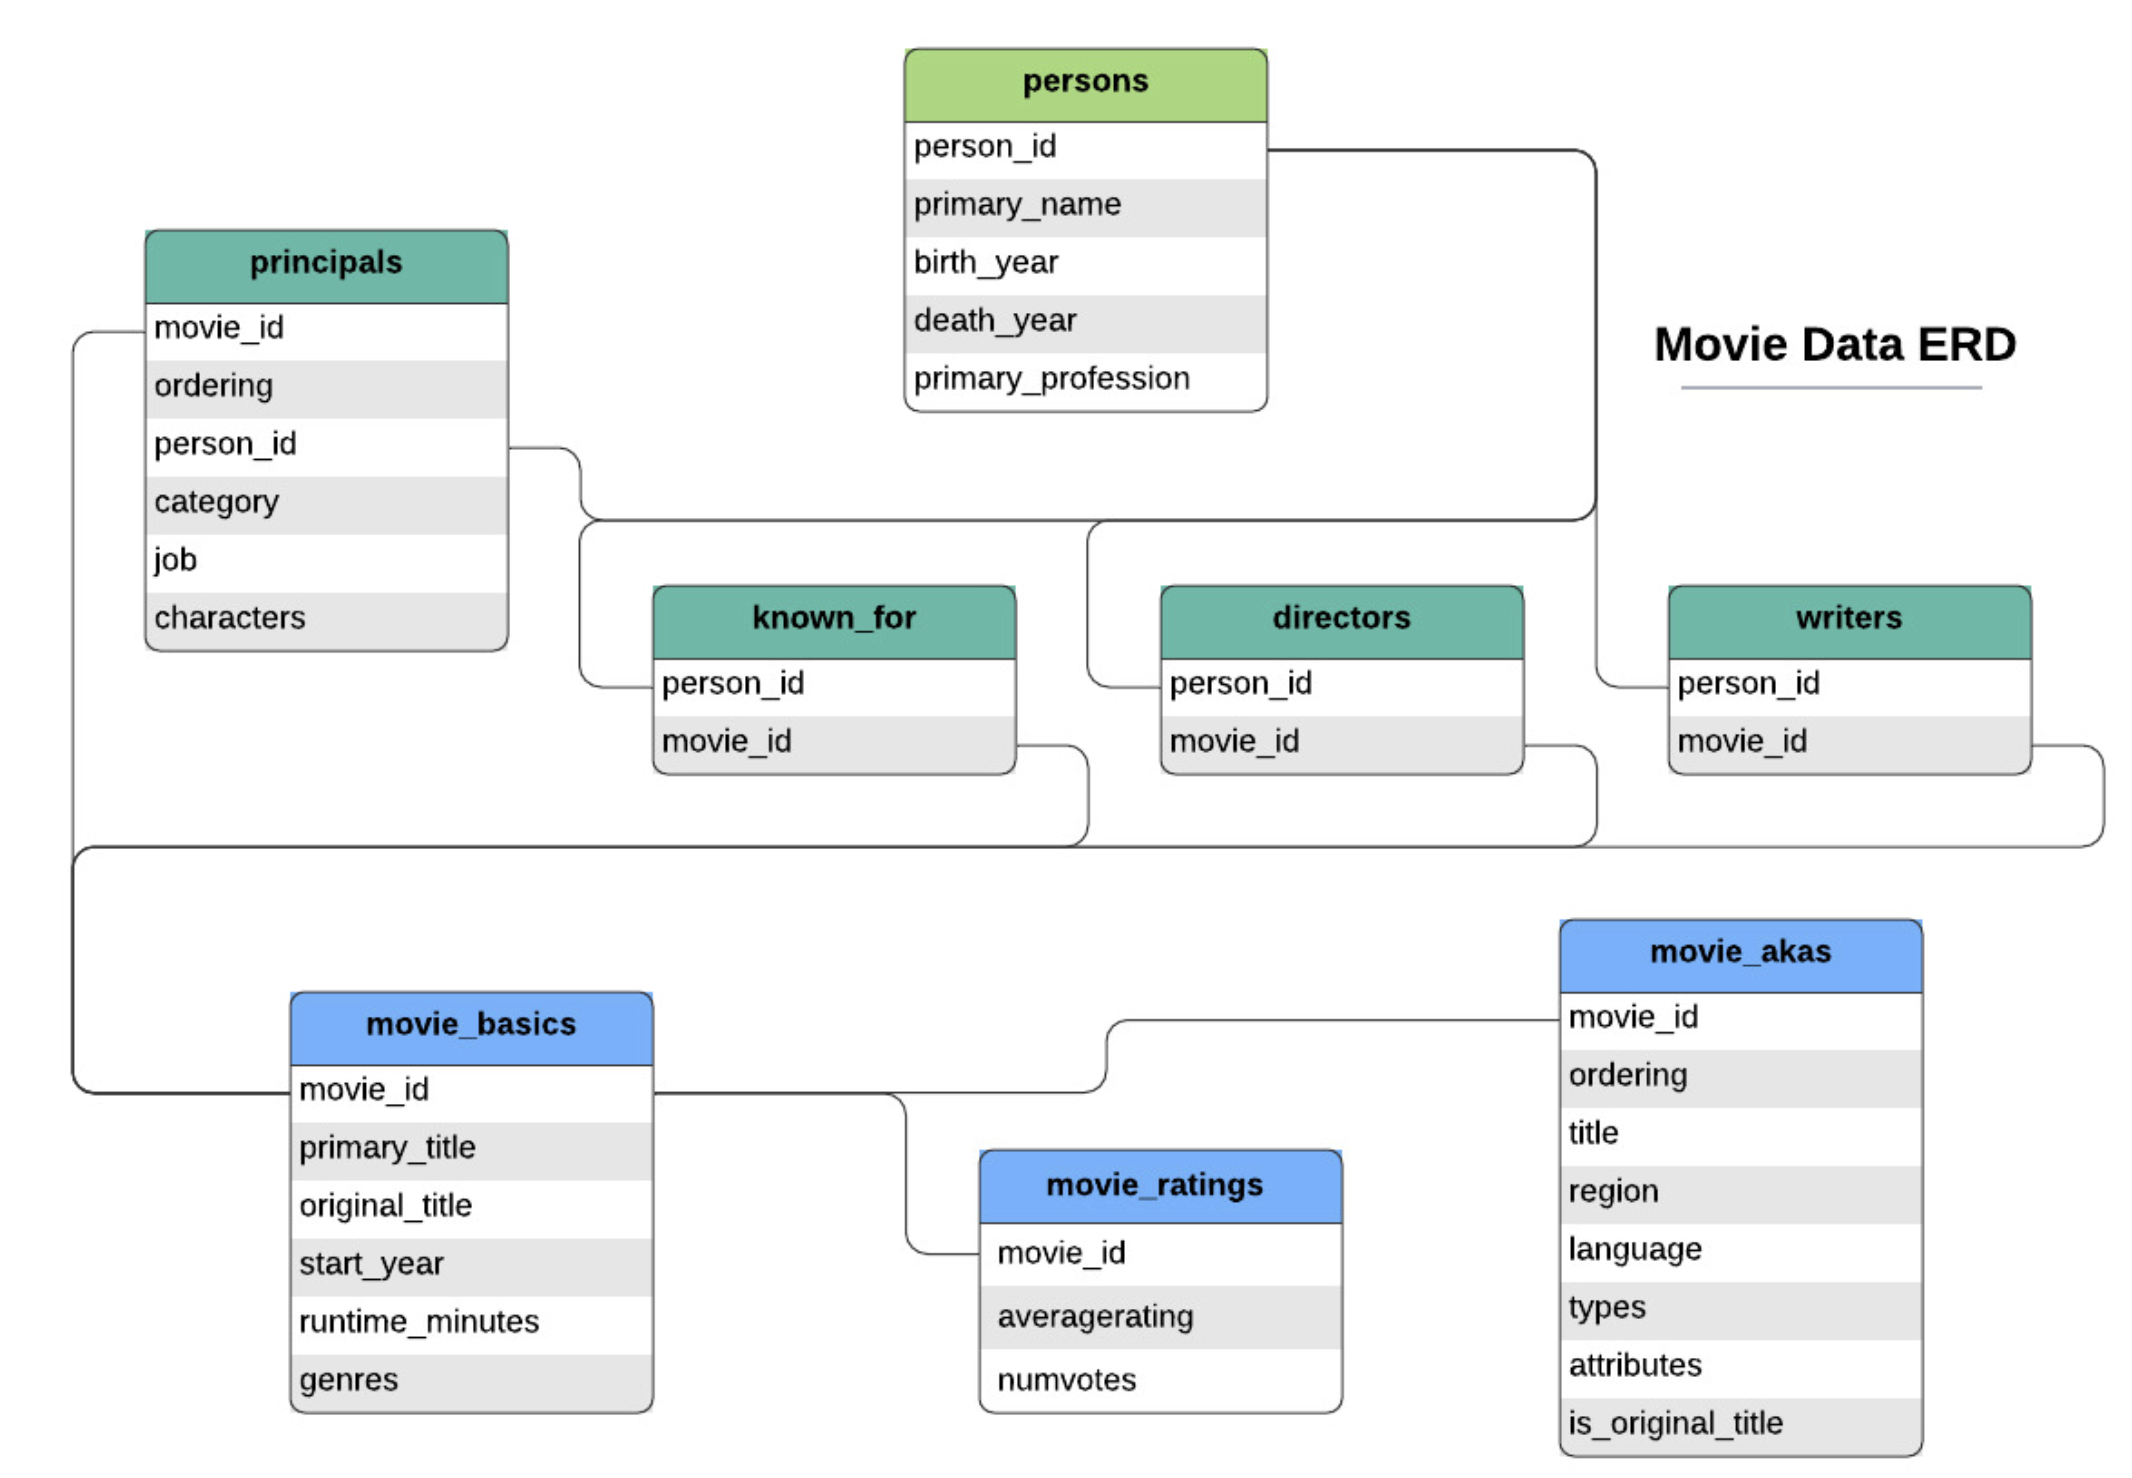

# Data Analysis

## Preparation

Before I begin my analysis, I need to make sure that I have the correct libraries loaded and that my data is clean.

In [85]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import seaborn as sns
import zipfile
import os

I need to unzip the files with the data so I can start to get a feel for it. For the SQLite database, I wrote a quick function to make it a little less tedious to write queries in Pandas.

In [9]:
# Unzip files
def sql(query):
    conn = sqlite3.connect('zippedData/im.db')
    curr = conn.cursor()
    sql_query = pd.read_sql_query(query, conn)
    return sql_query

bom_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
rt_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='latin_1')
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

# Eliminate rows I don't need from tmdb_movies
tmdb_movies_important = tmdb_movies[['genre_ids', 'original_title', 'popularity', 'vote_average', 'vote_count']]

Here are snapshots of the datasets I will primarily be using:

In [10]:
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [11]:
tmdb_movies_important.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   genre_ids       26517 non-null  object 
 1   original_title  26517 non-null  object 
 2   popularity      26517 non-null  float64
 3   vote_average    26517 non-null  float64
 4   vote_count      26517 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 1.0+ MB


In [14]:
conn = sqlite3.connect('zippedData/im.db')
curr = conn.cursor()
curr.execute("SELECT sql FROM sqlite_master WHERE name='movie_basics'")
fetchall = curr.fetchall()
print(fetchall)

[('CREATE TABLE "movie_basics" (\n"movie_id" TEXT,\n  "primary_title" TEXT,\n  "original_title" TEXT,\n  "start_year" INTEGER,\n  "runtime_minutes" REAL,\n  "genres" TEXT\n)',)]


For the purpose of my analysis, the budgets table will be very important because it has the most reliable list of worldwide gross revenues. I want to make sure that the data is clean. First, I removed the dollar signs and commas from budget and gross revenue columns with str.replace(). Then, I cast the columns as integers. This will allow me to perform calculations for net revenue and ROI, and lets me better visualize the data later on.

In [15]:
# Casting the gross revenues in the 'Budgets' table as integers
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace('$', '').str.replace(',', '')
budgets['production_budget'] = budgets['production_budget'].str.replace('$', '').str.replace(',', '')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$', '').str.replace(',', '')

budgets['worldwide_gross'] = budgets['worldwide_gross'].astype(int)
budgets['production_budget'] = budgets['production_budget'].astype(int)
budgets['domestic_gross'] = budgets['domestic_gross'].astype(int)

# Making sure the list is sorted by worldwide gross
budgets = budgets.sort_values(['worldwide_gross'], ascending=False)

# Sorting tmdb_movies by popularity
tmdb_movies_important = tmdb_movies_important.sort_values(['popularity'], ascending=False)

budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
42,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200
33,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864
...,...,...,...,...,...,...
5474,75,"Dec 31, 2005",Insomnia Manica,500000,0,0
5473,74,"Jul 17, 2012",Girls Gone Dead,500000,0,0
5472,73,"Apr 3, 2012",Enter Nowhere,500000,0,0
5471,72,"Dec 31, 2010",Drones,500000,0,0


Right off the bat, I see some outliers. At the top of the list, 'Avatar' had an extremely high budget, more than 100 million dollars higher than the next movie on the list. It also was the biggest moneymaker on the list, with over 2.7 billion dollars in gross revenue. There are only five movies on the list that have broken the 2 billion dollar threshold, with the next-highest grossing film bringing in 350 million dollars less. In a dataset of over 5000 movies, my assumption is that revenues drop precipitously outside of the super high-budget group. I will need to dig further into the data to see just how far apart these top films are from the rest of the pack.

In [16]:
budgets['worldwide_gross'].value_counts()

0           367
8000000       9
7000000       6
2000000       6
10000000      4
           ... 
4613482       1
57273049      1
1594955       1
23894000      1
3620902       1
Name: worldwide_gross, Length: 5356, dtype: int64

A quick value count shows that there is no revenue data for 367 movies. I don't want to flat-out remove these values, because 367 is not an insignificant amount of missing values. I also don't want to just assign the mean or median to all the missing values, since I don't think it's fair to assume an very low-budget or high-budget movie will have similar revenue. 

Since budgets are given for all entries, I think the best way to handle this would be to first find the quartiles for budgets and revenues. Then, I can find the median value within each revenue quartile and assign it to a film based on its budget quartile.

In [17]:
# Create a list without zeroes to find revenue quartiles
budgets_no_zeroes = budgets.loc[budgets['worldwide_gross'] != 0]

In [18]:
# Find budget quartiles
budget_q1 = budgets['production_budget'].quantile(0.25)
budget_median = budgets['production_budget'].median()
budget_q3 = budgets['production_budget'].quantile(0.75)

#Find revenue quartiles
revenue_q1 = budgets_no_zeroes['worldwide_gross'].quantile(0.25) 
revenue_median = budgets_no_zeroes['worldwide_gross'].median()
revenue_q3 = budgets_no_zeroes['worldwide_gross'].quantile(0.75)

# Fill in low-budget zeroes with the q1 median revenue
budgets.loc[(budgets['worldwide_gross'] == 0) & (budgets['production_budget'] < budget_q1), 'worldwide_gross'] = 1154360
budgets

#Remove any remaining zeroes
budgets_new = budgets.loc[budgets['worldwide_gross'] != 0]

In [19]:
# Update original budgets list
budgets = budgets_new
budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
42,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200
33,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864
...,...,...,...,...,...,...
5475,76,"Dec 31, 2014",America Is Still The Place,500000,0,1154360
5474,75,"Dec 31, 2005",Insomnia Manica,500000,0,1154360
5473,74,"Jul 17, 2012",Girls Gone Dead,500000,0,1154360
5472,73,"Apr 3, 2012",Enter Nowhere,500000,0,1154360


I was not able to replace all zeroes with quartile medians (the revenue column kept getting weird when I tried to replace high-budget films), but I was able to whittle the number of zeroes down to under 90. In this case, I feel comfortable removing those datapoints. In all, I was able to fill in low-budget quartile median values for about 300 movies.

The other two tables are much easier to clean, so I will work on those datasets during my analysis. Now that my revenue data is clean, I can begin exploring key business questions.

## Question 1: How does budget affect movie performance?

This recommendation will focus on whether there are certain budget ranges that produce optimal gross revenue and ROI. If there are multiple strong ranges, it would make sense for Microsoft to make more than one movie and diversify their offerings.

For this recommendation, it is important to consider both ROI and revenue. Microsoft has the resources to produce a high-budget movie, and will probably be interested in making significant revenue in addition to a solid return. If it is possible to make a higher-budget film with a similar ROI to successful low-budget films, that will be even better.

First, I want to make some new columns to represent net revenue and ROI. After that, I got some key budget metrics such as mean, median, standard deviation, and quartiles.

In [20]:
# Make new columns for net revenue and ROI
budgets['worldwide_net'] = budgets['worldwide_gross'] - budgets['production_budget']
budgets['ROI'] = (budgets['worldwide_net']/budgets['production_budget']) * 100

# Calculate mean, std, IQR, and CV
budget_std = budgets['production_budget'].std()
budget_mean = budgets['production_budget'].mean()
budget_iqr = budget_q3 - budget_q1
budget_cv = budget_std/budget_mean

print("Budget Standard Deviation:", budget_std)
print("Average Budget:", budget_mean)
print("Median Budget:", budget_median)
print("Q1 Budget:", budget_q1)
print("Q3 Budget:", budget_q3)
print("Budget IQR:", budget_iqr)
print("CV:", budget_cv)

Budget Standard Deviation: 42007494.775564484
Average Budget: 31746111.282627787
Median Budget: 17000000.0
Q1 Budget: 5000000.0
Q3 Budget: 40000000.0
Budget IQR: 35000000.0
CV: 1.3232327701992264


<ipython-input-20-a0091fb811f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  budgets['worldwide_net'] = budgets['worldwide_gross'] - budgets['production_budget']
<ipython-input-20-a0091fb811f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  budgets['ROI'] = (budgets['worldwide_net']/budgets['production_budget']) * 100


My suspicion was that the mean budget of 35 million dollars was being brought up pretty significantly by the ultra-high budget films at the top, and that seems to have been correct with a median of 17 million.

For budget, finding these values was easier because there is no missing data in that column. To find values for worldwide gross revenue, however, I will have to remove the zero-value movies before analyzing, as there are enough nulls to skew the data.

With a CV of 1.32, it's safe to say that the budget data has a high standard deviation and is relatively variable, meaning that the values are more spread out from the mean. This is probably due to the cluster of outliers towards the top of the dataset with very high budgets.

In [21]:
# Calculate revenue mean, std, IQR, and CV
revenue_mean = budgets_no_zeroes['worldwide_gross'].mean()
revenue_std = budgets_no_zeroes['worldwide_gross'].std()
revenue_iqr = revenue_q3 - revenue_q1
revenue_cv = revenue_std/revenue_mean

print("Revenue Standard Deviation:", revenue_std)
print("Average Revenue:", revenue_mean)
print("Median Revenue:", revenue_median)
print("Q1 Revenue:", revenue_q1)
print("Q3 Revenue:", revenue_q3)
print("Revenue IQR:", revenue_iqr)
print("CV:", revenue_cv)

Revenue Standard Deviation: 178859114.21999913
Average Revenue: 97687996.11468144
Median Revenue: 33339868.0
Q1 Revenue: 7004834.0
Q3 Revenue: 104459004.0
Revenue IQR: 97454170.0
CV: 1.830922133053342


The variability of the revenue data is even more significant. With a CV of 1.83, there is a very large spread in terms of revenue compared to the mean. This was fairly easy to see just from looking at the standard deviation, which is quite large at 178 million dollars. That is quite a bit higher than the average movie revenue, and more than 5x the median revnue of 33 million. This just goes to show how significantly that top cluster of movies effects this list. 

In [22]:
# Calculate median revenues for Q1 and Q3
low_revenue = budgets_no_zeroes.loc[budgets_no_zeroes['worldwide_gross'] <= revenue_q1]
high_revenue = budgets_no_zeroes.loc[budgets_no_zeroes['worldwide_gross'] >= revenue_q3]
low_revenue_median = low_revenue['worldwide_gross'].median()
high_revenue_median = high_revenue['worldwide_gross'].median()

print(low_revenue_median)
print(revenue_median)
print(high_revenue_median)

1154360.0
33339868.0
214962334.5


In [23]:
# Calculate the correlations between budget and revenue/ROI
# Calculate the mean ROI
revenue_correlation = budgets['production_budget'].corr(budgets['worldwide_gross'])
roi_correlation = budgets['production_budget'].corr(budgets['ROI'])
roi_mean = budgets['ROI'].mean()
print("Budget/Revenue Correlation:", revenue_correlation)
print("Budget/ROI Correlation:", roi_correlation)
print("Average ROI:", roi_mean)

Budget/Revenue Correlation: 0.7501397901702693
Budget/ROI Correlation: -0.05746440600260021
Average ROI: 435.2920795235458


When we take a look at the correlation between the budget and a couple different factors, we see some interesting results:

- Budget and gross revenue have a strong positive correlation, meaning that as budget increases, we tend to see revenue also increase pretty consistently.

- From an ROI perspective, there is actually a weak negative correlation, meaning that a higher budget may not meaningfully increase ROI and may actually diminish returns.

At face value, it would seem that, if your goal is to sell tickets, the sky is the limit when it comes to budget. As we can see, revenue raises steadily with budget. However, from an ROI perspective, a large budget doesn't necessarily make a significant, positive difference. With an average ROI of over 400%, though, does that lack of correlation matter? Is there a budget that will yield ideal ROI?

In [24]:
# Divide budgets into bins
budget_ranges = pd.qcut(budgets['production_budget'], q=16)

# Calculate average ROI by bin
roi_by_budget_range = budgets.groupby(budget_ranges)['ROI'].mean() 
print("ROI by Budget Range (%)")
roi_by_budget_range

ROI by Budget Range (%)


production_budget
(1099.999, 550000.0]          2952.143535
(550000.0, 1500000.0]          802.798634
(1500000.0, 3000000.0]         351.242327
(3000000.0, 5000000.0]         404.326561
(5000000.0, 7375770.5]         321.028692
(7375770.5, 10000000.0]        208.626764
(10000000.0, 13425000.0]       321.725362
(13425000.0, 17000000.0]       236.150337
(17000000.0, 20000000.0]       194.716961
(20000000.0, 25765000.0]       162.863906
(25765000.0, 32000000.0]       163.221060
(32000000.0, 40000000.0]       144.888961
(40000000.0, 51750000.0]       130.230925
(51750000.0, 70000000.0]       150.170379
(70000000.0, 103000000.0]      178.046876
(103000000.0, 425000000.0]     220.125991
Name: ROI, dtype: float64

Now that we can see where the weight of the high overall average ROI comes from, I want to also take a look at the same bins from a revenue perspective.

In [25]:
# Calculate average revenue by bin
revenue_by_budget_range = budgets.groupby(budget_ranges)['worldwide_gross'].mean() / 10**6
print("Revenue by Budget Range (millions)")
revenue_by_budget_range

Revenue by Budget Range (millions)


production_budget
(1099.999, 550000.0]            3.981190
(550000.0, 1500000.0]           8.778387
(1500000.0, 3000000.0]         11.096866
(3000000.0, 5000000.0]         22.027414
(5000000.0, 7375770.5]         26.840207
(7375770.5, 10000000.0]        28.248619
(10000000.0, 13425000.0]       49.519732
(13425000.0, 17000000.0]       50.980160
(17000000.0, 20000000.0]       57.009352
(20000000.0, 25765000.0]       62.595499
(25765000.0, 32000000.0]       76.866345
(32000000.0, 40000000.0]       91.246541
(40000000.0, 51750000.0]      108.572122
(51750000.0, 70000000.0]      152.272375
(70000000.0, 103000000.0]     236.269344
(103000000.0, 425000000.0]    519.836763
Name: worldwide_gross, dtype: float64

I used the .qcut() method to divide the budgets into 16 different bins and then calculated the average revenue and ROI for each bin. This method ensures that there are the same number of datapoints in each bin. I deemed that 16 bins was enough to really get a good look at how each bin breaks down. There are about 355 movies per bin. With this many bins, we essentially get to distill out the big-budget, blockbuster movies and contextualize them. When we look at the top band of budgets in the context of the lower-budget bins, we see that ROI really levels off at about 13 million dollars, and stay consistently below-average as we continue up the ladder.

Low-budget films are carrying the overall average ROI of 435%. This distribution suggests that Microsoft use their resources to take a diversified approach.

Let's take a look at some visualizations to further illuminate the data:

Text(0, 0.5, 'Mean ROI (%)')

<Figure size 1440x720 with 0 Axes>

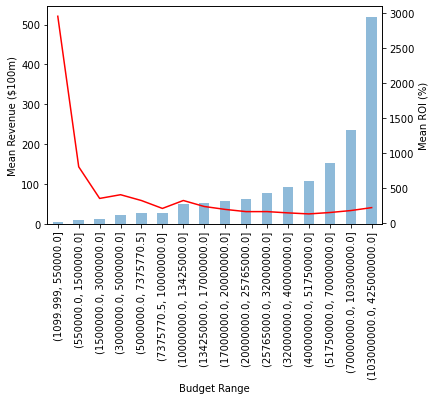

In [169]:
plt.figure(figsize=(20,10))
fig, ax1 = plt.subplots()

revenue_by_budget_range.plot.bar(ax=ax1, alpha=0.5, label='Mean Revenue (million $)')
ax1.set_xlabel('Budget Range')
ax1.set_ylabel('Mean Revenue ($100m)')

# Overlay line plot of ROI
ax2 = ax1.twinx()

roi_by_budget_range.plot(ax=ax2, color='red', label='Mean ROI (%)')
ax2.set_xlabel('Budget Range')
ax2.set_ylabel('Mean ROI (%)')

What we see here is revenue and ROI creating an almost symmetrical pattern across the chart. ROI begins very high in the low-budget range, then drops precipitously and plateaus with a slight downward trend, even as budgets (and revenue) soar.

In light of these trend, I recommend an overall starting budget of 650 million dollars, about 1% of Microsoft's free cash flow in 2022.

#### In order to establish themselves as a film studio and diversify risk profiles while delivering a good return, I recommend that Microsoft begins with the release of several films across various budget brackets. The breakdown would be as follows:
#### - Three films with budgets over 103 million dollars. These movies will not only produce outstanding revenue, but higher marketing budgets will do well to introduce Microsoft's new studio to the general public.
#### - Three films with budgets between 51 and 100 million dollars. Films in this category still generate strong revenues and high returns with less money on the table.
#### - Four films with budgets between 5 and 17 million dollars. Films in this category offer a far lower risk profile due to the money involved and superior return on investment.

#### This stragegy will allow Microsoft to enter multiple movie markets simultaneously. The higher-budget films will generate high revenues and mass appeal, while the lower-budget films appeal to niche communities while carrying low risk and high upside.

## Question 2: How does genre affect movie performance?

I want to examine the impact that a given genre has on the performance of a film. To get some data on this, I decided to combine the TMDb database (which contains movie genres) and my budget data.

In [27]:
# Combine tmdb table and budgets
genre_list = pd.merge(tmdb_movies, budgets, left_on='original_title', right_on='movie')

# Replace genre ids with names
genre_list['genre_ids'] = genre_list['genre_ids'].str.replace('12', 'Adventure').str.replace('28', 'Action').str.replace('14', 'Fantasy').str.replace('16', 'Animation').str.replace('10751', 'Family').str.replace('10402', 'Music').str.replace('878', 'Science Fiction').str.replace('35', 'Comedy').str.replace('80', 'Crime').str.replace('99', 'Documentary').str.replace('18', 'Drama').str.replace('10752', 'War').str.replace('37', 'Western').str.replace('53', 'Thriller').str.replace('10749', 'Romance').str.replace('9648', 'Mystery').str.replace('27', 'Horror').str.replace('36', 'History').str.replace('10770', 'TV Movie')
genre_list = genre_list.drop_duplicates(subset=['original_title'])
genre_list = genre_list.sort_values(['worldwide_gross'], ascending=False)
genre_list.head()

,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,title,vote_average,vote_count,id_y,release_date_y,movie,production_budget,domestic_gross,worldwide_gross,worldwide_net,ROI
6,6,"[Action, Adventure, Fantasy, Science Fiction]",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,553.257713
2137,23811,"[Adventure, Action, Fantasy]",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,582.711400
1446,14193,"[Action, Adventure, Science Fiction, Thriller]",135397,en,Jurassic World,20.709,2015-06-12,Jurassic World,6.6,14056,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864,666.909239
1451,14196,"[Action, Crime, Thriller]",168259,en,Furious 7,20.396,2015-04-03,Furious 7,7.3,6538,67,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,1328722794,699.327786
617,5179,"[Science Fiction, Action, Adventure]",24428,en,The Avengers,50.289,2012-05-04,The Avengers,7.6,19673,27,"May 4, 2012",The Avengers,225000000,623279547,1517935897,1292935897,574.638176


The above 'genre_ids' row contained several genre IDs that correspond to genres such as action, adventure, etc. I found the key online and proceeded to convert the IDs to the actual genre name. Now that I have a coherent genre list, I want to classify movies in a way that's easier to manipulate down the line. To do this, I'm going to organize them by primary genre (the first genre listed for a given movie).

Unfortunately, the 'genre_ids' column is not a list, but rather a string. That means I will first have to convert it to a list using commas as delimiters. Then, I can pluck the primary genre from each row and put it into my new column.

In [28]:
# Convert genre_ids to a list and strip brackets
genre_list['genre_ids'] = genre_list['genre_ids'].str.strip('[').str.strip(']')
genre_list['genre_ids'] = genre_list['genre_ids'].apply(lambda x: x.split(', '))

In [29]:
# Create new column for primary genre
genre_list['primary_genre'] = genre_list['genre_ids'].apply(lambda x: x[0])

In [30]:
genre_list.head()

,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,title,vote_average,vote_count,id_y,release_date_y,movie,production_budget,domestic_gross,worldwide_gross,worldwide_net,ROI,primary_genre
6,6,"[Action, Adventure, Fantasy, Science Fiction]",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,553.257713,Action
2137,23811,"[Adventure, Action, Fantasy]",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,582.711400,Adventure
1446,14193,"[Action, Adventure, Science Fiction, Thriller]",135397,en,Jurassic World,20.709,2015-06-12,Jurassic World,6.6,14056,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864,666.909239,Action
1451,14196,"[Action, Crime, Thriller]",168259,en,Furious 7,20.396,2015-04-03,Furious 7,7.3,6538,67,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,1328722794,699.327786,Action
617,5179,"[Science Fiction, Action, Adventure]",24428,en,The Avengers,50.289,2012-05-04,The Avengers,7.6,19673,27,"May 4, 2012",The Avengers,225000000,623279547,1517935897,1292935897,574.638176,Science Fiction


Now that I have a column of primary genres, I can begin to make calculations based on that information. I want to figure out the mean revenue and mean ROI for each genre. That information can be used to make a concrete recommendation on which genres make the most money and which are most profitable. The cell below will calculate the average revenues and ROIs based on primary genre.

In [72]:
# Calculate average revenues and ROIs by primary genre
mean_revenue_list = genre_list.groupby('primary_genre')['worldwide_gross'].mean()
mean_roi_list = genre_list.groupby('primary_genre')['ROI'].mean()

print("Mean List (in millions):")
# Divide the original list by 1,000,000, bypassing default display
print(mean_list / 1000000)
print('')
print('ROI List (%):')
print(roi_list)

Mean List (in millions):
primary_genre
                    38.967753
Action             262.648414
Adventure          295.166963
Animation          281.741657
Comedy              67.822095
Crime               63.658282
Documentary         57.188375
Drama               55.279065
Family             252.143043
Fantasy            184.906508
History             85.766505
Horror              55.090285
Music               54.200696
Mystery             72.866091
Romance             86.767352
Science Fiction    218.578925
TV Movie           112.191528
Thriller            67.910008
War                113.365125
Western            135.592482
Name: worldwide_gross, dtype: float64

ROI List (%):
primary_genre
                    524.672984
Action              196.915544
Adventure           246.511386
Animation           302.711807
Comedy              235.778073
Crime               155.660252
Documentary         316.995911
Drama               252.738719
Family              308.407021
Fantasy        

In the revenue data, we can see some trends at a glance. There are only five categories that average over 200 million dollars in revenue. In order from highest to lowest, they are:
- Adventure (295m)
- Animation (281m)
- Action (262m)
- Family (252m)
- Science Fiction (218m)

At first, it was surprising to see animated and family movies competing with blockbuster action movies, but one must remember that their target audience is vast. It turns out that animated/family movies are also among the most profitable projects, with the two categories averaging about 305% returns.

Horror movies yield by far the highest return on investment at 1133%, but they average significantly less revenue. This suggests that there are many lower-budget horror movies that overperform. Other high-return categories include:
- Science Fiction (457%)
- Mystery (427%)
- Documentary (316%)
- History (313%)

While combing the data, I also noticed that 'Frozen', one of the highest-grossing films ever, has been listed as a Thriller when it could be primarly listed as an Animated/Family movie. This would only bolster animated films' position on the revenue and ROI boards.

The chart below breaks down revenue and ROI by genre:

Text(0, 0.5, 'Mean ROI (%)')

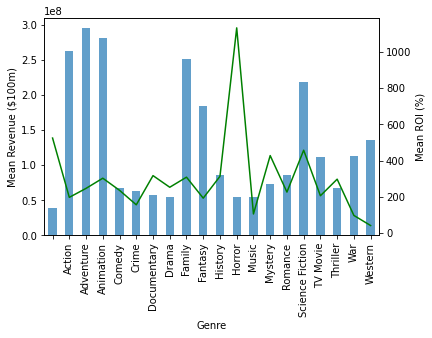

In [176]:
# Plot mean revenue bar chart
fig, ax1 = plt.subplots()
mean_revenue_list.plot.bar(ax=ax1, alpha=0.7, label='Mean Revenue ($100m)')
ax1.set_xlabel('Genre')
ax1.set_ylabel('Mean Revenue ($100m)')

# Overlay line plot of ROI
ax2 = ax1.twinx()

mean_roi_list.plot(ax=ax2, color='green', label='Mean ROI (%)')
ax2.set_xlabel('Genre')
ax2.set_ylabel('Mean ROI (%)')

This chart helps visualize my mean revenue and ROI findings. The "le8" on the top left indicates the amount of zeroes on the end of the mean revenue values on the y-axis. 

While there are some clear revenue winners, the ROI chart is much more closely clustered (apart from horror movies). However, we do see that we can yield higher returns with lower-revenue genres. This would suggest that a diversified approach would enable Microsoft to produce several films with lower expected revenue but higher expected ROI. These movies also can serve to fill those lower-budget slots in their portfolio.

Looking at the top of the dataset, it is very easy to get caught up in the generational numbers that a few action and adventure movies have posted. The top ten highest-grossing films of all time fall into one of those categories. 

However, after some close analysis, it is clear that animated films offer higher upside. They are cheaper to make and offer higher significantly higher returns than other top earners. 

#### Therefore, I can confidently recommend that Microsoft focus a significant portion of their budget on making animated films.
Animated movies are extremely competitive in overall revenue and have a stronger ROI than other top-earning genres. Animated movies can also have other high-earning elements integrated into them. The remainder of Microsoft's budget should go primarily towards action and adventure films, and they could consider adding a horror film and/or a documentary to broaden their appeal while making strong returns.

## Question 3: How does runtime affect movie performance?

I want to see if runtime has an impact on how well a movie does. To do this, I will get runtime data from the im.db database and merge it with my revenue and ROI data.

First, I want to write a query that gets me the information I need from im.db.

In [36]:
# Get runtime data
runtime_list = sql("""
SELECT primary_title, runtime_minutes
FROM movie_basics;""")

Now that I have the runtime data, I can combine that table with my budgets table.

In [37]:
# Merge SQL table with budgets data
runtimes = pd.merge(runtime_list, budgets, left_on='primary_title', right_on='movie')

# Sort by gross revenue and drop duplicates
runtimes = runtimes.sort_values('worldwide_gross', ascending=False)
runtimes = runtimes.drop_duplicates(subset='primary_title')
runtimes

,primary_title,runtime_minutes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_net,ROI
1717,Avatar,93.0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,553.257713
2706,Titanic,115.0,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2008208395,1004.104198
3279,Avengers: Infinity War,149.0,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,582.711400
12,Jurassic World,124.0,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864,666.909239
2869,Furious 7,137.0,67,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,1328722794,699.327786
...,...,...,...,...,...,...,...,...,...,...
2907,Higher Power,93.0,67,"May 11, 2018",Higher Power,500000,528,528,-499472,-99.894400
3601,Bang,NaN,70,"Apr 1, 1996",Bang,10000,527,527,-9473,-94.730000
2068,Destiny,NaN,84,"Dec 31, 2014",Destiny,750000,0,450,-749550,-99.940000
2338,Food Chains,83.0,36,"Nov 21, 2014",Food Chains,913000,0,176,-912824,-99.980723


I notice that some runtime columns contain missing values. I need to remove these to make sure I get the most accurate picture of the data.

In [38]:
runtimes = runtimes.dropna(subset=['runtime_minutes'])
runtimes

,primary_title,runtime_minutes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_net,ROI
1717,Avatar,93.0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,553.257713
2706,Titanic,115.0,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2008208395,1004.104198
3279,Avengers: Infinity War,149.0,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,582.711400
12,Jurassic World,124.0,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864,666.909239
2869,Furious 7,137.0,67,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,1328722794,699.327786
...,...,...,...,...,...,...,...,...,...,...
1960,The Looking Glass,80.0,58,"Oct 23, 2015",The Looking Glass,300000,1711,1711,-298289,-99.429667
1073,Eddie: The Sleepwalking Cannibal,90.0,25,"Apr 5, 2013",Eddie: The Sleepwalking Cannibal,1400000,1632,1632,-1398368,-99.883429
1276,Skin Trade,78.0,19,"May 8, 2015",Skin Trade,9000000,1242,1242,-8998758,-99.986200
2907,Higher Power,93.0,67,"May 11, 2018",Higher Power,500000,528,528,-499472,-99.894400


Now that the data is clean and ordered, I can begin to make some calculations on how runtime affects a film's moneymaking ability.

In [39]:
# Calculate mean, median, and standard deviation
runtime_mean = runtimes['runtime_minutes'].mean()
runtime_median = runtimes['runtime_minutes'].median()
runtime_std = runtimes['runtime_minutes'].std()

print("Average Runtime:", runtime_mean)
print("Median Runtime:", runtime_median)
print("Runtime Standard Deviation:", runtime_std)

Average Runtime: 101.65221579961464
Median Runtime: 101.0
Runtime Standard Deviation: 24.18344449947009


So, the mean and the median runtimes are basically the same. This means that the data is fairly symmetrical, suggesting a very nice bell-shaped distribution around the central value.

Just from skimming the top of the data, there seems to be a fairly healthy distribution of runtimes in high-grossing films. 'Avatar', the highest-grossing film ever, was significantly shorter than some of the others in the top 10, coming in at only 93 minutes. Let's do some analysis to see how much of an outlier movies like 'Avatar' are.

I want to start by dividing runtimes up into bins. We can use qcut() to form bins of runtimes and then calculate the average revenue and returns of movies that fall into each bin.

In [142]:
# Calculate revenue by runtime range
runtime_ranges = pd.qcut(runtimes['runtime_minutes'], q=8)
revenue_by_runtime_range = runtimes.groupby(runtime_ranges)['worldwide_gross'].mean() / 1000000
runtime_correlation = runtimes['runtime_minutes'].corr(runtimes['worldwide_gross'])

print("Runtime/Revenue Correlation:", runtime_correlation)
print("")
print("Revenues by Runtime Range (millions)")
revenue_by_runtime_range

Runtime/Revenue Correlation: 0.22300733554551436

Revenues by Runtime Range (millions)


runtime_minutes
(0.999, 83.0]         62.271118
(83.0, 90.0]          57.350497
(90.0, 95.0]          88.540935
(95.0, 101.0]         82.998869
(101.0, 107.0]       110.320646
(107.0, 113.25]      103.480657
(113.25, 124.625]    153.594080
(124.625, 360.0]     268.424792
Name: worldwide_gross, dtype: float64

When we look at revenue by runtime, it's clear that longer movies make much more money. Many big-budget blockbusters fall into the high-runtime category, which accounts for its distance from the next category down. While the final figure of 268 million dollars should be taken with a grain of salt due to a lower sample size in that range, this result is in line with the positive correlation between runtime and revenue of 0.22.

We know longer movies can make money, but do they also have the best returns? Let's take a look.

In [143]:
# Calculate ROI by runtime range
runtime_ranges = pd.qcut(runtimes['runtime_minutes'], q=8)
roi_by_runtime_range = runtimes.groupby(runtime_ranges)['ROI'].mean()
print("ROI by Runtime Range (millions)")
roi_by_runtime_range

ROI by Runtime Range (millions)


runtime_minutes
(0.999, 83.0]        1146.430270
(83.0, 90.0]          326.097048
(90.0, 95.0]          261.006664
(95.0, 101.0]         223.164164
(101.0, 107.0]        249.517747
(107.0, 113.25]       240.380572
(113.25, 124.625]     224.895047
(124.625, 360.0]      281.728767
Name: ROI, dtype: float64

Some interesting results here. We see the trend almost completely reverse, with low-runtime movies blowing all the other ROIs out of the water at 748%. The rest of the pack gets a much tighter spread. High-runtimes still win out, but runtimes closer to the median are a lot more competitive.

So it seems that, if generating revenue is the goal, a higher-runtime movie is the way to go. However, if it's returns you're after, movies on the lower end of the runtime range work much better.

We can further examine these trends by creating a scatter plot of revenue data:

Text(0.5, 1.0, 'Runtime vs. Gross Revenue (with Trendline)')

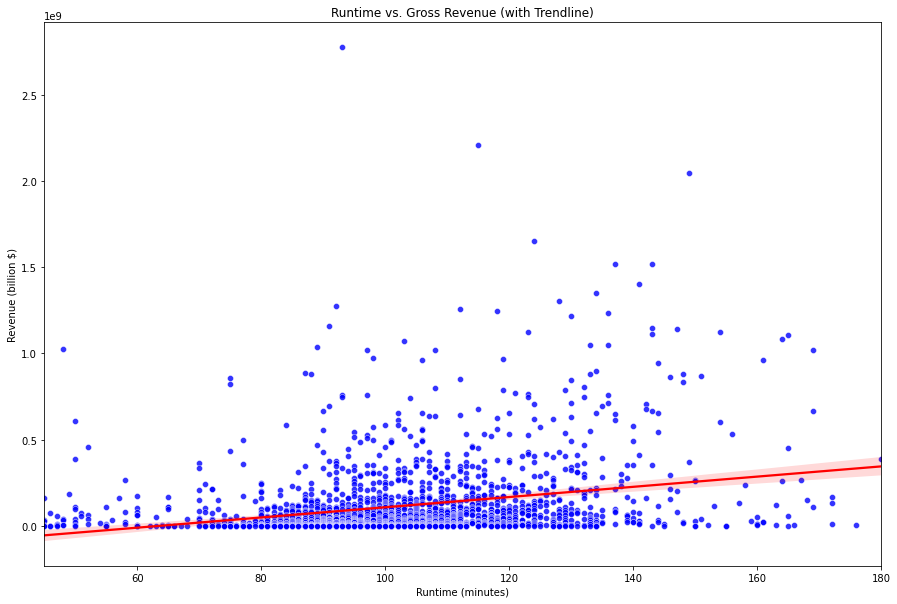

In [141]:
plt.figure(figsize=(15, 10))
# Filter runtimes to eliminate outliers
filtered_runtimes = runtimes.loc[(runtimes['runtime_minutes'] >= 45) & (runtimes['runtime_minutes'] <= 180)]
# Create scatterplot
sns.scatterplot(data=filtered_runtimes, x='runtime_minutes', y='worldwide_gross', color='blue', alpha=0.8)
# Add trendline
sns.regplot(data=filtered_runtimes, x='runtime_minutes', y='worldwide_gross', color='red', scatter=False)
# Add labels
plt.xlabel("Runtime (minutes)")
plt.ylabel("Revenue (billion $)")
plt.title("Runtime vs. Gross Revenue (with Trendline)")

This scatterplot lines up with general revenue expectations. The bulk of the datapoints create a loose bell shape between 70 and 140 minutes. The bulk of movies in this range are making very similar amounts of money (as indicated by the dense cluster of points), but we can see a gradual trend upwards as we see those higher-revenue datapoints begin to float higher and higher up as we increase runtime to about 140 minutes. Beyond that runtime, it's not really clear that making longer movies is worth it, as those datapoints begin to float down a bit.

Understanding ROI is a simpler proposition:

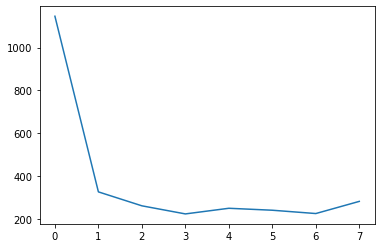

In [149]:
plt.plot(roi_by_runtime_range)

Even after we get past the low-runtime outliers, we see a steady decline and then a plateau as runtime increases. So, while shorter runtimes do seem to promise higher returns, beyond 95 minutes it's not clear how much ROI will improve.

#### My runtime recommendation falls in line with the budget and genre strategies: diversify. 

- For high-budget movies, I would recommend a runtime longer than 113 minutes, as this yields higher revenue.

- Shorter runtimes are more compatible with animated and family movies, as those are generally geared towards a younger audience and often are shorter. Producing an animated film that comes in around 90 minutes should create a potent mix of genre-drive revenue and runtime-based ROI.

# Conclusions

This analysis led to three key business recommendations for Microsoft as they open their new studio:
- <b>Produce ten films across multiple budget brackets, with a total studio budget of 650 million dollars.<b>
- <b>Focus resources on producing at least one animated film, with a secondary focus on action and adventure movies.<b>
- <b>Diversify runtimes, with higher-budget movies being longer than 113 minutes and lower-budget films being closer to 90 minutes.<b>

My recommendations work together to form a coherent strategy: Using high-budget films to generate the bulk of the revenue and market the studio, while using low-budget films to generate high returns and appeal to niche audiences. This strategy properly diversifies Microsoft's film portfolio and balances risk while still being capable of producing high returns.

### Next Steps

Further analyses could yield other actionable insights for Microsoft. These include:
- <b>Synergies between primary and secondary genre.<b>
- <b>Genre performance by runtime.<b>
- <b>Leading actor effect on revenue/ROI.<b>